In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_09c import *

# Data augmentation 

## PIL transforms

In [3]:
#export
make_rgb._order=0

In [44]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
def get_il(tfms):
    return ImageList.from_files(path, tfms=tfms)

In [6]:
il = get_il(tfms)

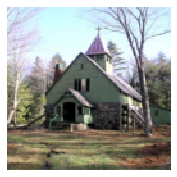

In [7]:
show_image(il[0])

In [8]:
img = PIL.Image.open(il.items[0])

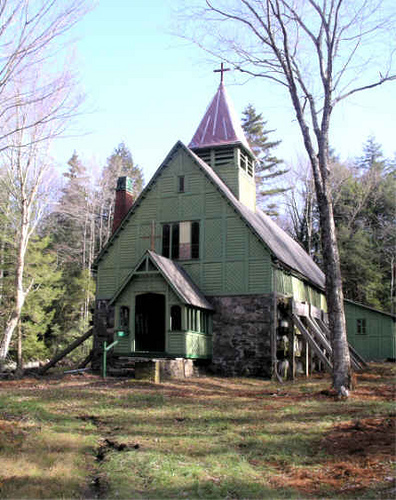

In [9]:
img

In [10]:
import numpy as np

In [11]:
img.size, img.mode, img.format

((396, 500), 'RGB', 'JPEG')

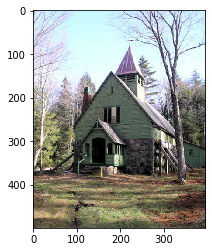

In [12]:
plt.imshow(np.array(img))

In [13]:
img.getpixel((1,1))

(234, 240, 255)

In [14]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[0]))

3.33 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


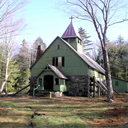

In [15]:
img.resize((128, 128), resample=PIL.Image.ANTIALIAS)

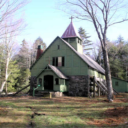

In [16]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

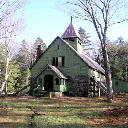

In [17]:
img.resize((128,128), resample=PIL.Image.NEAREST)

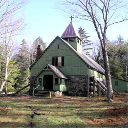

In [18]:
img.resize((256, 256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [19]:
%timeit img.resize((224, 224), resample=PIL.Image.BICUBIC)

1.63 ms ± 334 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit img.resize((224, 224), resample=PIL.Image.BILINEAR)

1.01 ms ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.NEAREST)

29.8 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Flip 

In [22]:
#export
import random

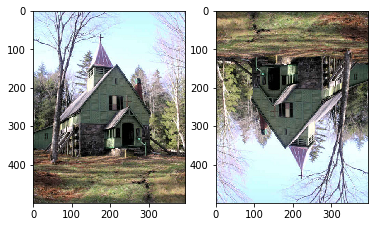

In [23]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(img.transpose(PIL.Image.FLIP_LEFT_RIGHT))
axes[1].imshow(img.transpose(PIL.Image.FLIP_TOP_BOTTOM))

In [24]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [45]:
def print_tfms(tfms):
    for t in tfms:
        order = getattr(t, "_order", 0)
        if hasattr(t, '__name__'):
            print(t.__name__, order)
        elif hasattr(t, "__class__"):
            print(t.__class__.__name__, order)
        
print_tfms(tfms)

make_rgb 0
ResizeFixed 10
to_byte_tensor 20
to_float_tensor 30


In [46]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*64
dl = DataLoader(il1, 8)

In [47]:
x = next(iter(dl))

In [48]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))
    
def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3, r*3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for xi, ax in zip(x, axes.flat): show_image(xi, ax)    

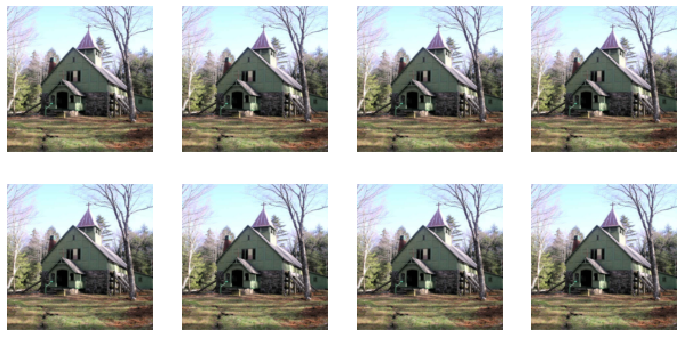

In [49]:
show_batch(x)

In [50]:
il1.tfms.append(pil_random_flip)

In [52]:
print_tfms(il1.tfms)

make_rgb 0
ResizeFixed 10
to_byte_tensor 20
to_float_tensor 30
pil_random_flip 0


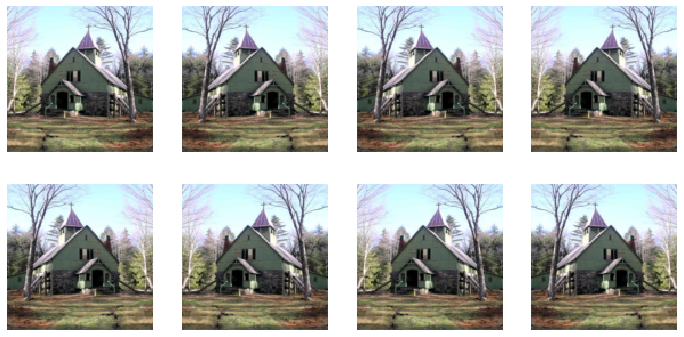

In [53]:
x = next(iter(dl))
show_batch(x)

In [54]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [55]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [56]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

In [57]:
print_tfms(il1.tfms)

make_rgb 0
ResizeFixed 10
to_byte_tensor 20
to_float_tensor 30
PilRandomFlip 11


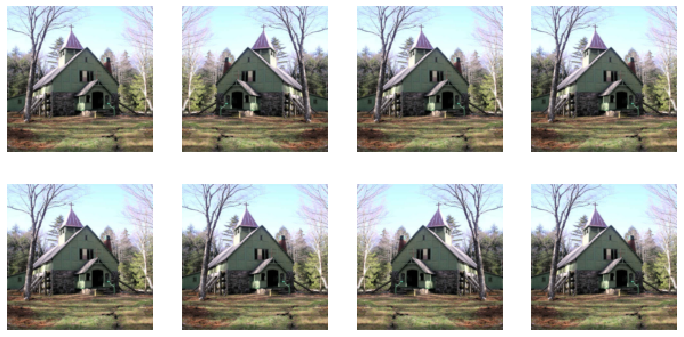

In [59]:
x = next(iter(dl))
show_batch(x)

In [61]:
PIL.Image.ROTATE_90, PIL.Image.ROTATE_180, PIL.Image.ROTATE_270

(2, 3, 4)

In [62]:
PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.FLIP_TOP_BOTTOM

(0, 1)

In [63]:
PIL.Image.TRANSPOSE, PIL.Image.TRANSVERSE

(5, 6)

In [64]:
PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.ROTATE_270, PIL.Image.TRANSVERSE

(0, 4, 6)

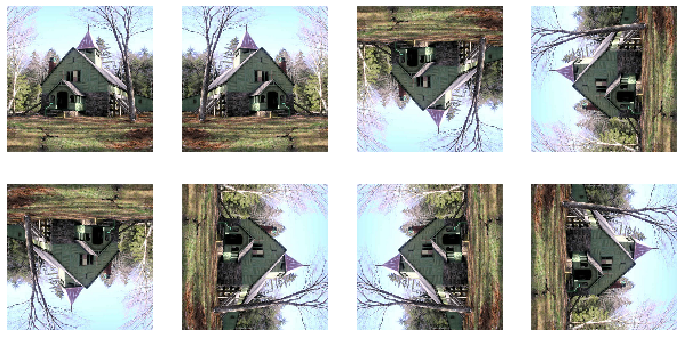

In [65]:
img = PIL.Image.open(il.items[0])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis("off")

In [73]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8
    def __call__(self, x):
        if random.random() > self.p: return x
        return x.transpose(random.randint(0,6)) # randomly pick 1 of 7 transforms

In [74]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

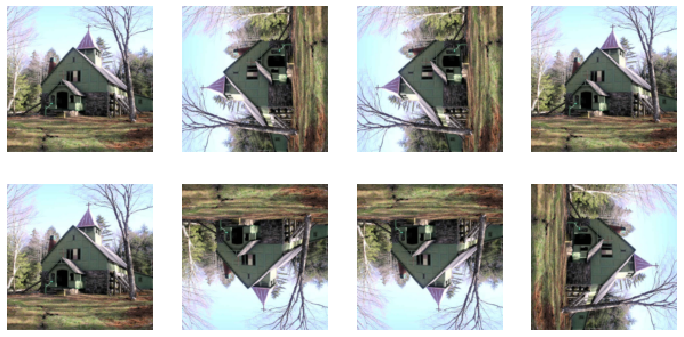

In [75]:
show_batch(next(iter(dl)))

## Random crop 

In [76]:
img = PIL.Image.open(il.items[0])
img.size

(396, 500)

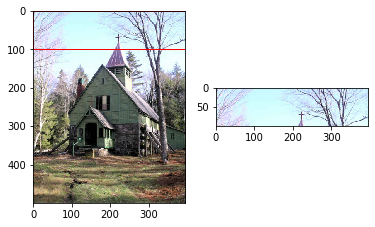

In [77]:
import matplotlib.patches as patches

fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
rect = patches.Rectangle(
    (0,0),396,100,linewidth=1,edgecolor='r',facecolor='none')
axes[0].add_patch(rect)

axes[1].imshow(img.crop((0, 0, 396, 100)))

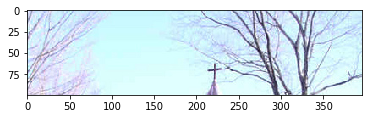

In [78]:
plt.imshow(np.array(img.crop((0, 0, 396, 100))))

In [79]:
w, h = img.size
cx, cy = w//2, h//2
cx, cy

(198, 250)

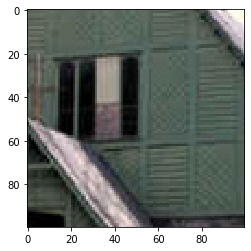

In [80]:
plt.imshow(img.crop((cx-50, cy-50, cx+50, cy+50)))

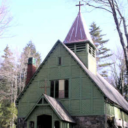

In [81]:
img.crop((60, 60, 320, 320)).resize((128,128), resample=PIL.Image.BILINEAR)

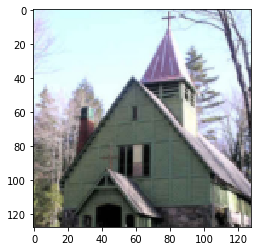

In [82]:
plt.imshow(img.crop((60, 60, 320, 320)).resize((128,128), resample=PIL.Image.BILINEAR))

In [83]:
def f(left, upper, right, lower):
    return img.crop((left, upper, right, lower))

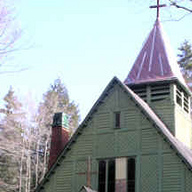

In [84]:
f(64, 64, 256, 256)

In [85]:
cnr2 = (60, 60, 320, 320)
resample = PIL.Image.BILINEAR

In [86]:
%timeit -n 10 img.crop(cnr2).resize((128, 128), resample=resample)

348 µs ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
img.transform??

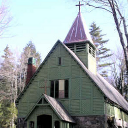

In [89]:
img.transform((128, 128), PIL.Image.EXTENT, cnr2, resample=resample)

Here we go about how to put a time constraint. We can process 130 images per second (125M images, 8 gpus, with a 5 min constraint per batch). Thus 1/125 is the time per image which is roughly about 10ms. So we need our trnasforms and network calculation to be less than 10ms

In [90]:
1250000/8/5/60/4 # we can process 130 image per second (125M images, 8 gpus, w)

130.20833333333334

In [91]:
1/125.

0.008

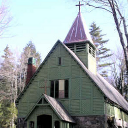

In [92]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [93]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

351 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [95]:
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

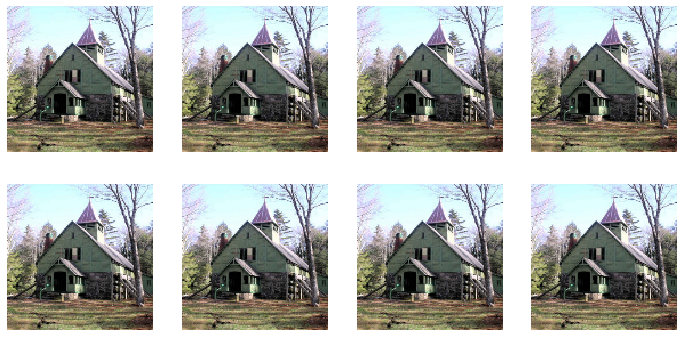

In [96]:
show_batch(next(iter(dl)))

### RandomResizeCrop 

In [97]:
# export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to squish
        if   w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else:                     size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

In [98]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

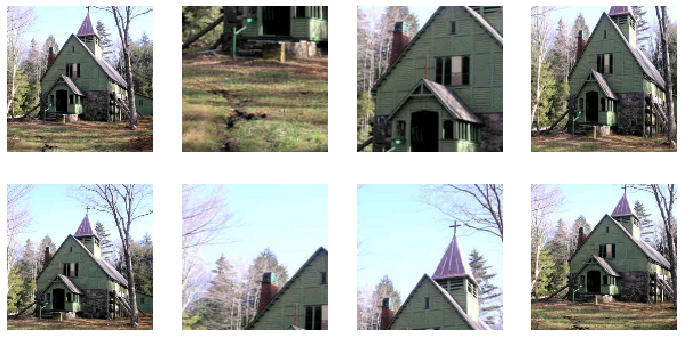

In [99]:
show_batch(next(iter(dl)))

In [100]:
# export
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [101]:
# export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [102]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

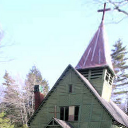

In [103]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [104]:
%timeit -n 10 warp(img, (128,128), src)

437 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

152 µs ± 6.06 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


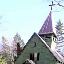

In [106]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

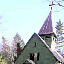

In [107]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [108]:
# export
def uniform(a,b): return a + (b-a) * random.random()

In [109]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [110]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

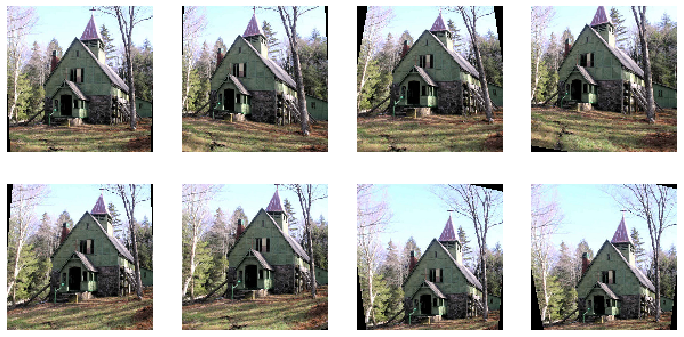

In [111]:
x = next(iter(dl))
show_batch(x)

In [112]:
# export
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [113]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 200, magnitude=0.2), to_byte_tensor, to_float_tensor]

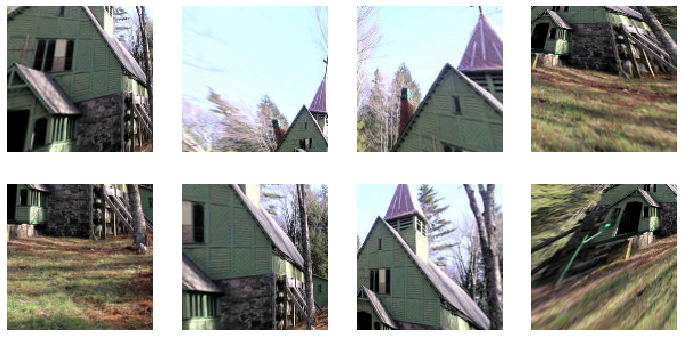

In [114]:
x = next(iter(dl))
show_batch(x)

### Faster tensor creation 

In [115]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

## Export 

In [116]:
!python notebook2script.py 10_augmentation.ipynb

Converted 10_augmentation.ipynb to exp/nb_10.py
